<a href="https://colab.research.google.com/github/freyaldi/learn-machine-learning-development/blob/main/natural-language-processing/nlp_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Emotion Classification**

In [1]:
# install kaggle and upload kaggle json to download dataset
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ferzareyaldi","key":"e51e2f00de3943063b2c338476100b4a"}'}

In [2]:
#download and unzip emotion dataset
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d praveengovi/emotions-dataset-for-nlp
! unzip emotions-dataset-for-nlp.zip

100% 721k/721k [00:00<00:00, 878kB/s]
100% 721k/721k [00:00<00:00, 878kB/s]
Archive:  emotions-dataset-for-nlp.zip
  inflating: test.txt                
  inflating: train.txt               
  inflating: val.txt                 


In [26]:
#imported libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

In [27]:
#read dataset
df_train = pd.read_csv('train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('test.txt', names=['Text', 'Emotion'], sep=';')

In [28]:
#combine all data to do preprocessing
df= new_df_train = pd.concat([df_train, df_val, df_test])
df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


In [29]:
#one-hot encoding for label
label = pd.get_dummies(df.Emotion)
label

,anger,fear,joy,love,sadness,surprise
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,1,0,0,0,0,0
3,0,0,0,1,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
1995,1,0,0,0,0,0
1996,1,0,0,0,0,0
1997,0,0,1,0,0,0
1998,0,0,1,0,0,0


In [30]:
#merge the one-hot encoding label and drop label column
new_df = pd.concat([df, label], axis=1)
new_df = new_df.drop(columns='Emotion')
new_df

,Text,anger,fear,joy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
...,...,...,...,...,...,...,...
1995,i just keep feeling like someone is being unki...,1,0,0,0,0,0
1996,im feeling a little cranky negative after this...,1,0,0,0,0,0
1997,i feel that i am useful to my people and that ...,0,0,1,0,0,0
1998,im feeling more comfortable with derby i feel ...,0,0,1,0,0,0


In [31]:
#convert dataframe into array
statement = new_df['Text'].values
label = new_df[['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']].values

In [32]:
statement

array(['i didnt feel humiliated',
       'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
       'im grabbing a minute to post i feel greedy wrong', ...,
       'i feel that i am useful to my people and that gives me a great feeling of achievement',
       'im feeling more comfortable with derby i feel as though i can start to step out my shell',
       'i feel all weird when i have to meet w people i text but like dont talk face to face w'],
      dtype=object)

In [33]:
label

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

In [34]:
#split data
statement_train, statement_test, label_train, label_test = train_test_split(statement, label, test_size=0.2)

In [35]:
#convert text into token into sequence into padded sequence

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=2000, oov_token='<oov>')
tokenizer.fit_on_texts(statement_train)
tokenizer.fit_on_texts(statement_test)

seq_train = tokenizer.texts_to_sequences(statement_train)
seq_test = tokenizer.texts_to_sequences(statement_test)

padded_train = tf.keras.preprocessing.sequence.pad_sequences(seq_train)
padded_test = tf.keras.preprocessing.sequence.pad_sequences(seq_test)

In [36]:
#callback function
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nBoth train and val accuracy has reached 92%")
      self.model.stop_training = True

callbacks = myCallback()

In [37]:
#build and compile model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=2000, output_dim=16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [38]:
#train the model
history = model.fit(padded_train, label_train, epochs=50,
                    validation_data=(padded_test, label_test), callbacks=[callbacks], verbose=1)

Epoch 1/50
500/500 [==============================] - 19s 31ms/step - loss: 1.5184 - accuracy: 0.3879 - val_loss: 1.2820 - val_accuracy: 0.5058
Epoch 2/50
500/500 [==============================] - 7s 15ms/step - loss: 0.8563 - accuracy: 0.6908 - val_loss: 0.6268 - val_accuracy: 0.7870
Epoch 3/50
500/500 [==============================] - 5s 11ms/step - loss: 0.5269 - accuracy: 0.8197 - val_loss: 0.5695 - val_accuracy: 0.8198
Epoch 4/50
500/500 [==============================] - 8s 16ms/step - loss: 0.4161 - accuracy: 0.8605 - val_loss: 0.4347 - val_accuracy: 0.8525
Epoch 5/50
500/500 [==============================] - 6s 12ms/step - loss: 0.3556 - accuracy: 0.8823 - val_loss: 0.3739 - val_accuracy: 0.8675
Epoch 6/50
500/500 [==============================] - 5s 11ms/step - loss: 0.3083 - accuracy: 0.8923 - val_loss: 0.3191 - val_accuracy: 0.8850
Epoch 7/50
500/500 [==============================] - 5s 11ms/step - loss: 0.2630 - accuracy: 0.9048 - val_loss: 0.3222 - val_accuracy: 0.892

In [42]:
#plot function
def show_plot(train_plot, val_plot, title):
  plt.plot(train_plot)
  plt.plot(val_plot)
  plt.title(title)
  plt.ylabel(title)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

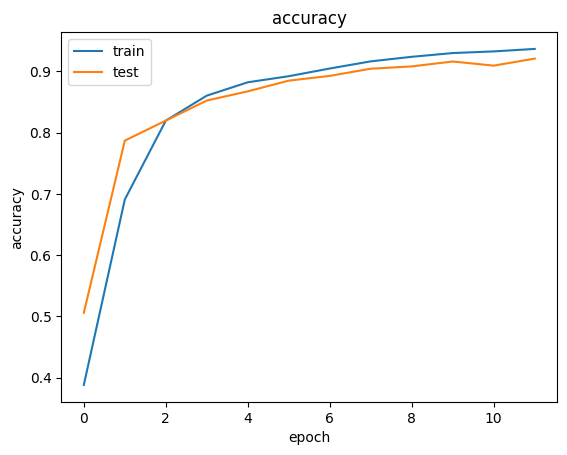

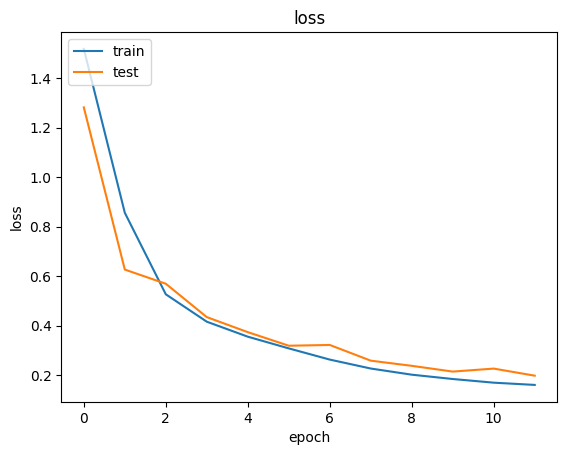

In [43]:
#visualize accuracy and loss progress
show_plot(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')
show_plot(history.history['loss'], history.history['val_loss'], 'loss')